In [1]:
import numpy as np
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Lambda, Layer
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle


2024-06-27 21:09:42.081791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 21:09:43.067126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_images(images, title, n_rows=10, n_cols=10):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[:n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_latent_space(compressed_data, labels):
    plt.figure(figsize=(8, 8))
    plt.scatter(compressed_data[:, 0], compressed_data[:, 1], c=labels, cmap='viridis', s=2)
    plt.colorbar()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()

In [3]:
data_dir = '../../data'

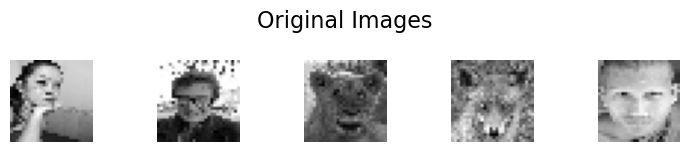

In [4]:
def load_image_data(data_dir, img_size=(28, 28)):
    labels = ['portrait', 'other']
    data = []
    label_data = []
    for label in labels:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0
            data.append(img_array.flatten())
            label_data.append(labels.index(label))
    data, label_data = shuffle(np.array(data), np.array(label_data))
    return data, label_data

data, label_data = load_image_data(data_dir)
plot_images(data, title='Original Images', n_rows=1, n_cols=5)


In [13]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [38]:
class VAELossLayer(Layer):
    def __init__(self, input_dim, **kwargs):
        self.input_dim = input_dim
        super(VAELossLayer, self).__init__(**kwargs)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_sum(tf.square(inputs - outputs), axis=-1)
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return tf.reduce_mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        inputs, outputs, z_mean, z_log_var = inputs
        loss = self.vae_loss(inputs, outputs, z_mean, z_log_var)
        self.add_loss(loss)
        return outputs

In [39]:
def create_vae(input_dim, encoding_dim):

    # Encoder
    inputs = Input(shape=(input_dim,))
    h1 = Dense(128, activation='relu')(inputs)
    h2 = Dense(64, activation='relu')(h1)
    z_mean = Dense(encoding_dim)(h2)
    z_log_var = Dense(encoding_dim)(h2)

    # Création de vecteurs latents avec la moyenne et la variance
    z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(encoding_dim,))
    h3 = Dense(64, activation='relu')(latent_inputs)
    h4 = Dense(128, activation='relu')(h3)
    outputs = Dense(input_dim, activation='sigmoid')(h4)

    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE qui reconstruit les vecteurs latents en optimisant la perte de reconstruction
    outputs = decoder(encoder(inputs)[2])
    vae_loss_layer = VAELossLayer(input_dim)([inputs, outputs, encoder(inputs)[0], encoder(inputs)[1]])
    vae = Model(inputs, vae_loss_layer, name='vae')
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

In [40]:
def train_vae(data, encoding_dim, epochs=500, batch_size=256):
    input_dim = data.shape[1]
    vae, encoder, decoder = create_vae(input_dim, encoding_dim)
    vae.fit(data, epochs=epochs, batch_size=batch_size, shuffle=True)
    return encoder, decoder, vae

encoder, decoder, vae = train_vae(data, encoding_dim=2)

Epoch 1/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 49.7677
Epoch 2/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 38.8977
Epoch 3/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 38.2647
Epoch 4/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.9187
Epoch 5/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.5798
Epoch 6/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 37.6268
Epoch 7/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 37.5358
Epoch 8/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.3926
Epoch 9/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.3187
Epoch 10/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 37.3326
Epoch 11/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.3706
Epoch 12/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.2961
Epoch 13/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 37.3496
Epoch 14/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 37.1589
Epoch 15/500
173/17

1382/1382 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


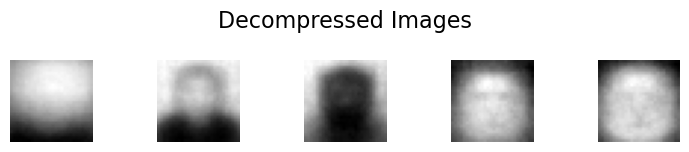

In [41]:

def compress(data, encoder):
    return encoder.predict(data)[0]

def decompress(compressed_data, decoder):
    return decoder.predict(compressed_data)

compressed_data = compress(data, encoder)
decompressed_data = decompress(compressed_data, decoder)
plot_images(decompressed_data, title='Decompressed Images', n_rows=1, n_cols=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


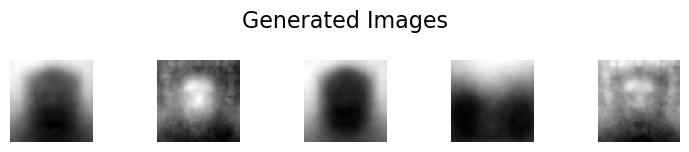

In [42]:
def generate_new_images(decoder, encoding_dim, n_images=10, noise_level=0.5):
    new_images = []
    for _ in range(n_images):
        random_encoded = np.random.normal(scale=noise_level, size=(1, encoding_dim))
        new_image = decoder.predict(random_encoded)
        new_images.append(new_image.reshape(28, 28))
    return np.array(new_images)

generated_images = generate_new_images(decoder, 2)
plot_images(generated_images, title='Generated Images', n_rows=1, n_cols=5)


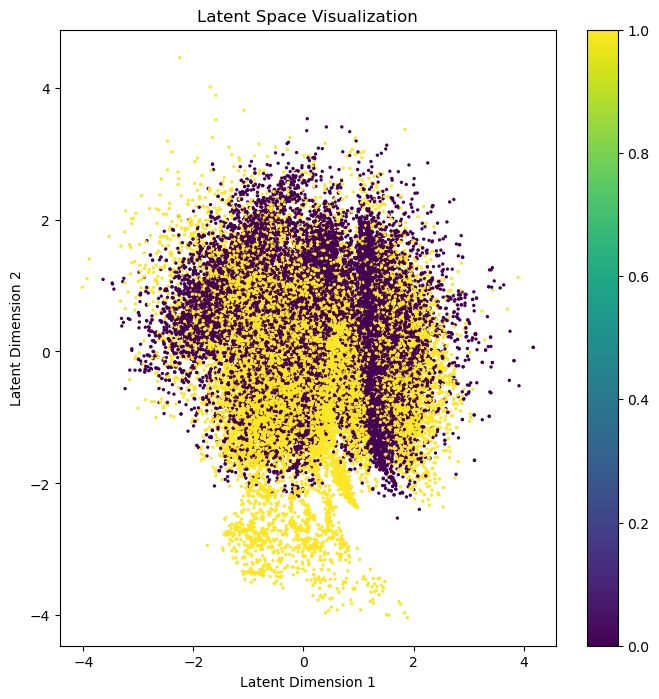

In [44]:
plot_latent_space(compressed_data, label_data)